In [1]:
%env CUDA_VISIBLE_DEVICES=2

#!pip install datasets transformers[sentencepiece]
#!pip install ipywidgets
#!pip install torchsummary 
#!pip install accelerate 
#!pip3 install matplotlib

# cf: Huggingface
# https://colab.research.google.com/github/huggingface/notebooks/blob/master/course/chapter3/section4.ipynb#scrollTo=nZ09SFwfjXNO
# Google
# https://colab.research.google.com/github/501Good/tartu-nlp-2020/blob/master/labs/lab6/Lab6_TransformersClassification.ipynb#scrollTo=yfUd-Wr3t7rO

env: CUDA_VISIBLE_DEVICES=2


# Configuration

In [2]:
from datasets import load_dataset, ClassLabel, load_metric
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
import numpy as np
import torch
import os
import pandas as pd
import matplotlib.pyplot as plt
from torchinfo import summary

# xzl
config_batch_size = 8
config_per_sample = True   # otherwise per minibatch
config_n_window = config_batch_size * 16 # mov window avg for cal loss threshold, in num of samples 

In [3]:
# # load pre-trained
# #  ... many weights are not init'd... random??

tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')
model = AutoModelForSequenceClassification.from_pretrained('distilbert-base-uncased')
metric = load_metric("accuracy")

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classi

In [4]:
#  dump model 
#
# cf: 
# https://stackoverflow.com/questions/68577198/pytorch-summary-fails-with-huggingface-model
# https://stackoverflow.com/questions/68585678/pytorch-summary-fails-with-huggingface-model-ii-expected-all-tensors-to-be-on-t
# torch info doc: 
# https://github.com/TylerYep/torchinfo
# ... works, but not very helpful
# summary(model,input_size=(8,512), dtypes=['torch.IntTensor'], device='cpu',verbose=1) 

#for name, param in model.named_parameters():
#    if param.requires_grad:
#        print(name, param.size())

## (save model)

In [5]:
# #######################
# # save model ...
# ########################
# # Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

# output_dir = './model_save/'

# # Create output directory if needed
# if not os.path.exists(output_dir):
#     os.makedirs(output_dir)

# print("Saving model to %s" % output_dir)

# # Save a trained model, configuration and tokenizer using `save_pretrained()`.
# # They can then be reloaded using `from_pretrained()`
# model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
# model_to_save.save_pretrained(output_dir)
# tokenizer.save_pretrained(output_dir)

# # Good practice: save your training arguments together with the trained model
# # torch.save(args, os.path.join(output_dir, 'training_args.bin'))

## (load a saved model)

In [6]:
# Load a trained model and vocabulary that you have fine-tuned

#output_dir = './distilbert/model_save/'  # VScode needs this relative path??
# output_dir = './model_save/'  # VScode needs this relative path??

# model = AutoModelForSequenceClassification.from_pretrained(output_dir)
# tokenizer = AutoTokenizer.from_pretrained(output_dir)
# metric = load_metric("accuracy")

# freeze transformer layers (TODO: freeze other layers??)
# for param in model.distilbert.parameters():
#     param.requires_grad = False

In [7]:
# xzl: this???
os.environ["WANDB_DISABLED"] = "true"

def to_bin_class(ex):
	ex['label'] = round(ex['label'])
	return ex

def tokenize_fn(ex):
	return tokenizer(ex['sentence'], padding='max_length', truncation=True)

def compute_metrics(eval_pred):
	logits, labels = eval_pred
	preds = np.argmax(logits, axis=-1)
	return metric.compute(predictions=preds, references=labels)

# load training data

In [8]:
sst = load_dataset('sst', 'default')
#sst = load_dataset('glue', 'sst2')
sst = sst.remove_columns(['tokens', 'tree'])
sst = sst.map(to_bin_class)
sst = sst.cast_column('label', ClassLabel(num_classes=2))

sst_tokenized = sst.map(tokenize_fn, batched=True)

Reusing dataset sst (/u/xl6yq/.cache/huggingface/datasets/sst/default/1.0.0/b8a7889ef01c5d3ae8c379b84cc4080f8aad3ac2bc538701cbe0ac6416fb76ff)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached processed dataset at /u/xl6yq/.cache/huggingface/datasets/sst/default/1.0.0/b8a7889ef01c5d3ae8c379b84cc4080f8aad3ac2bc538701cbe0ac6416fb76ff/cache-175e01bd44ae6e77.arrow
Loading cached processed dataset at /u/xl6yq/.cache/huggingface/datasets/sst/default/1.0.0/b8a7889ef01c5d3ae8c379b84cc4080f8aad3ac2bc538701cbe0ac6416fb76ff/cache-bcfe3eb7a84204f3.arrow
Loading cached processed dataset at /u/xl6yq/.cache/huggingface/datasets/sst/default/1.0.0/b8a7889ef01c5d3ae8c379b84cc4080f8aad3ac2bc538701cbe0ac6416fb76ff/cache-d17996794240dda4.arrow
Loading cached processed dataset at /u/xl6yq/.cache/huggingface/datasets/sst/default/1.0.0/b8a7889ef01c5d3ae8c379b84cc4080f8aad3ac2bc538701cbe0ac6416fb76ff/cache-a4488ee52a49920a.arrow
Loading cached processed dataset at /u/xl6yq/.cache/huggingface/datasets/sst/default/1.0.0/b8a7889ef01c5d3ae8c379b84cc4080f8aad3ac2bc538701cbe0ac6416fb76ff/cache-1c1de7b235a26b22.arrow
Loading cached processed dataset at /u/xl6yq/.cache/huggingface/datasets/ss

In [9]:
sst_tokenized = sst_tokenized.remove_columns(['sentence'])

trn_set = sst_tokenized['train']
num_trn = trn_set.num_rows
trn_set_10 = torch.utils.data.Subset(trn_set, list(range(0,int(num_trn/10))))
trn_set_50 = torch.utils.data.Subset(trn_set, list(range(0,int(num_trn/2))))
tst_set = sst_tokenized['test']
val_set = sst_tokenized['validation']

print(val_set.column_names)

['label', 'input_ids', 'attention_mask']


In [10]:
sst2 = load_dataset('glue', 'sst2')
sst2 = sst2.map(to_bin_class)
sst2 = sst2.cast_column('label', ClassLabel(num_classes=2))

sst2_tokenized = sst2.map(tokenize_fn, batched=True)

sst2_tokenized = sst2_tokenized.remove_columns(['sentence'])

Reusing dataset glue (/u/xl6yq/.cache/huggingface/datasets/glue/sst2/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached processed dataset at /u/xl6yq/.cache/huggingface/datasets/glue/sst2/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad/cache-a7fd750de98eccdc.arrow
Loading cached processed dataset at /u/xl6yq/.cache/huggingface/datasets/glue/sst2/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad/cache-cb82f2b3146ed290.arrow
Loading cached processed dataset at /u/xl6yq/.cache/huggingface/datasets/glue/sst2/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad/cache-cc351fc2d3a49113.arrow
Loading cached processed dataset at /u/xl6yq/.cache/huggingface/datasets/glue/sst2/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad/cache-ee0643d23beb47af.arrow
Loading cached processed dataset at /u/xl6yq/.cache/huggingface/datasets/glue/sst2/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad/cache-44f2a071873c044a.arrow
Loading cached processed dataset at /u/xl6yq/.cache/huggingface/datasets/glue/sst2/1.

In [11]:
trn_set = sst_tokenized['train']
num_trn = trn_set.num_rows
tst_set = sst_tokenized['test']
val_set = sst_tokenized['validation']

print(val_set.column_names)

['label', 'input_ids', 'attention_mask']


In [12]:
# data loader, split into train/eval sets
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

from torch.utils.data import DataLoader

train_dataloader = DataLoader(
   trn_set, shuffle=True, batch_size=config_batch_size, collate_fn=data_collator
   # trn_set_100, shuffle=False, batch_size=config_batch_size, collate_fn=data_collator
    # trn_set_500, shuffle=False, batch_size=config_batch_size, collate_fn=data_collator    
    # trn_set_1000, shuffle=False, batch_size=config_batch_size, collate_fn=data_collator    
)
eval_dataloader = DataLoader(
    val_set, batch_size=config_batch_size, collate_fn=data_collator
)

In [13]:
# a batch is a dict. k is col name, e.g. 'input_ids'. v is a 2D tensor (8x512 in our case)

# sanity check data ...
for batch in train_dataloader:
    break
{k: v.shape for k, v in batch.items()}    
#batch.items()
#print(batch['input_ids'])
#print("train #batches=",len(train_dataloader))
#print("val #batches=",len(eval_dataloader))

{'input_ids': torch.Size([8, 512]),
 'attention_mask': torch.Size([8, 512]),
 'labels': torch.Size([8])}

In [14]:
# run one batch
outputs = model(**batch)
print(outputs.loss, outputs.logits.shape)
print(outputs)
# probablity
print(torch.nn.functional.softmax((outputs.logits),dim=1))

tensor(0.7016, grad_fn=<NllLossBackward0>) torch.Size([8, 2])
SequenceClassifierOutput(loss=tensor(0.7016, grad_fn=<NllLossBackward0>), logits=tensor([[0.1380, 0.0837],
        [0.1505, 0.0821],
        [0.0861, 0.0649],
        [0.1394, 0.0643],
        [0.1557, 0.0693],
        [0.0854, 0.1204],
        [0.0933, 0.0995],
        [0.1518, 0.1260]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)
tensor([[0.5136, 0.4864],
        [0.5171, 0.4829],
        [0.5053, 0.4947],
        [0.5188, 0.4812],
        [0.5216, 0.4784],
        [0.4913, 0.5087],
        [0.4984, 0.5016],
        [0.5064, 0.4936]], grad_fn=<SoftmaxBackward0>)


In [15]:
# ... prep optim lr scheduler etc  ... 
#from transformers import AdamW    # deprecated
from torch.optim import AdamW

optimizer = AdamW(model.parameters(), lr=5e-5)
# optimizer.param_groups[0]['params']
# print(len(optimizer.param_groups[0]['params']))

'''
for t in optimizer.param_groups[0]['params']:
    print(t.shape)
'''

"\nfor t in optimizer.param_groups[0]['params']:\n    print(t.shape)\n"

In [16]:
from transformers import get_scheduler

num_epochs = 1    # xzl. default:3

num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)
print(num_training_steps)

import torch

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)
print(device)
# print(model)  # can be useful

#summary(model,input_size=(8,512)) # ... type errors??

1068
cuda


In [17]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

# excluded_batches = []
# bottom 50%
# excluded_batches = [0,2,6,5,1,4,3,8,7,10,9,11,581,870,525,785,12,13,827,811,422,973,1021,14,320,967,140,122,583,624,935,542,936,924,618,777,22,591,888,331,32,593,852,813,297,825,15,156,687,30,75,1029,643,538,774,19,530,234,287,25,724,943,316,93,978,427,384,611,464,750,900,361,432,519,208,760,553,625,336,982,111,179,312,104,471,26,845,17,68,855,695,139,293,177,552,144,897,548,706,1036,856,379,482,902,627,500,817,814,415,601,18,726,557,20,860,100,229,249,332,103,355,948,939,1049,824,579,822,895,450,1027,896,467,80,456,266,202,736,887,260,185,1062,974,1028,1060,781,933,165,309,255,480,240,700,108,232,461,993,184,381,458,296,1022,88,1001,395,323,91,1000,69,991,330,359,965,727,63,851,347,253,995,916,697,917,584,152,690,616,957,463,1006,843,76,466,378,135,663,286,50,770,410,539,201,92,879,506,647,70,236,245,998,181,248,404,741,29,954,209,306,246,119,268,949,133,1026,1056,418,449,196,682,221,918,863,806,1019,992,65,125,24,821,66,692,56,739,243,617,554,1015,397,550,416,79,748,95,406,409,149,1017,89,281,174,512,367,469,445,696,251,648,753,944,121,694,702,54,592,575,675,926,990,264,284,205,150,123,963,167,180,898,613,755,794,16,118,448,36,884,176,681,674,454,913,72,844,84,128,776,485,130,861,452,385,164,772,529,834,319,838,789,227,883,1011,468,988,479,672,274,803,407,1058,722,265,77,701,254,258,388,346,622,31,460,572,1033,413,698,484,38,612,1013,805,473,890,962,751,573,1047,637,462,389,956,113,951,927,375,937,282,82,197,244,971,168,98,33,964,368,382,451,1010,64,55,163,365,1031,537,1039,829,328,1025,603,833,641,324,711,880,486,459,1065,629,650,470,373,420,457,653,220,472,147,666,83,533,223,496,656,160,439,1023,947,1018,742,294,713,508,878,858,301,910,735,975,871,498,795,175,731,200,109,350,693,628,1024,28,157,342,730,551,646,1012,351,516,819,279,638,433,901,532,831,792,396,689,455,985,21,931,363,968,972,57,137,941,411,453,699,154,477,414,986,345,81,492,143,73,679,474,1009,206,425,952,145,1067,210,124,981,364,830,652,290,169,872,676,358,798,1005,899,773,906,636,678,325,869,172,400,252,846,441,745,570,1037,510,131,1064,737,606,644,231,360,1061,215,534,170,178,857,1032,408,994,812,1007,651,784,356,]
# bottom 75%
# excluded_batches = [16,4,12,18,6,7,22,13,9,19,11,5,2,14,17,20,25,21,15,3,10,27,24,8,1,29,23,30,28,26,0,32,31,670,34,630,943,168,979,225,33,92,940,599,595,989,456,1064,930,131,106,432,35,695,916,726,592,1014,453,729,565,622,117,806,637,258,1061,36,672,783,846,750,908,794,490,312,378,484,1047,814,144,980,854,947,145,404,318,566,781,498,506,1013,971,874,159,613,83,692,681,689,118,699,259,289,183,77,1002,128,60,415,417,160,1018,151,130,910,583,1043,679,684,139,1017,43,1010,757,1006,765,52,157,995,928,277,460,402,718,913,500,147,122,898,996,61,970,288,135,133,124,962,522,994,655,40,441,37,81,576,349,245,138,134,467,1031,38,50,529,774,961,333,914,45,915,963,905,74,152,964,430,362,330,201,331,395,337,1001,79,984,525,357,303,323,901,374,297,80,585,638,226,548,344,615,266,835,591,517,62,938,355,360,519,274,140,602,890,184,353,804,667,559,717,701,586,683,429,46,265,189,568,69,324,364,923,1036,499,472,937,827,521,82,85,343,687,282,438,792,745,222,72,112,580,171,464,927,291,121,120,268,569,75,925,627,501,748,546,55,785,1027,166,639,992,893,494,551,71,238,485,713,818,39,444,839,41,359,326,363,563,70,1011,953,823,990,673,325,859,78,746,843,656,960,669,577,1042,316,101,919,273,252,126,396,153,346,508,883,663,177,575,668,845,798,696,856,84,716,286,997,132,405,371,777,561,345,180,398,653,311,877,579,719,214,423,918,67,205,53,113,116,832,369,208,191,966,791,452,768,356,632,676,751,269,448,424,541,123,816,1055,550,873,865,380,372,657,926,543,704,86,851,1040,457,641,974,564,137,281,942,694,707,150,219,270,256,413,658,470,891,427,1065,944,648,742,428,262,852,284,903,597,520,414,193,198,838,691,301,626,549,959,710,909,253,954,310,581,574,382,786,491,711,473,685,836,931,620,154,584,329,878,65,876,848,59,475,822,706,42,820,682,93,828,801,367,322,451,882,635,279,594,532,582,573,217,264,216,867,866,129,978,1041,693,304,870,934,476,437,879,283,255,612,1054,624,233,513,739,425,643,320,1046,795,531,54,88,110,342,347,759,702,540,784,552,468,678,336,148,948,474,1039,246,642,976,399,1050,528,410,351,335,842,275,250,847,922,523,1032,1025,956,115,659,1058,334,76,190,267,108,778,315,932,125,486,888,352,516,988,633,397,578,478,221,1052,800,524,629,570,744,287,588,951,872,408,730,477,981,993,158,892,858,375,810,299,769,447,459,697,767,298,728,731,849,857,841,601,686,544,790,675,203,1004,1016,366,542,328,714,646,920,703,507,143,605,621,212,1020,412,753,977,911,936,808,454,889,338,982,518,896,560,272,443,276,509,57,824,895,593,502,1044,493,327,952,1051,875,625,688,645,63,793,787,73,619,1021,611,881,211,512,321,674,392,618,897,871,278,271,945,819,975,377,571,407,481,1045,662,724,169,426,968,339,572,194,370,439,230,514,261,463,983,383,368,782,607,972,213,306,254,234,690,812,533,1059,434,955,887,526,244,156,406,985,912,465,48,864,141,341,361,698,302,290,803,249,965,598,294,207,829,805,869,700,431,422,680,204,305,884,178,44,241,416,1009,243,192,537,248,202,98,837,538,365,215,536,181,1037,285,752,487,868,661,715,1003,175,182,530,164,247,419,185,949,223,172,732,562,723,503,917,1057,142,236,280,296,587,721,821,505,545,608,1030,780,735,87,206,969,497,558,567,504,96,308,257,89,99,510,1053,97,95,834,797,736,483,492,855,939,830,802,924,666,471,705,167,603,853,]

# -- include all --- #
included_batches = list(range(0, len(train_dataloader)))

# loss, top 10 
# included_batches = [0,12,606,28,908,14,629,647,229,961,683,156,921,84,868,74,1031,801,7,296,948,219,525,343,624,29,466,56,203,55,436,260,643,266,11,153,112,636,308,664,781,927,106,1024,465,197,726,19,278,90,173,50,533,53,42,925,357,77,902,612,281,318,799,43,911,263,422,111,259,198,71,225,482,832,723,782,790,588,476,689,904,383,479,631,139,556,771,1061,253,51,719,728,941,392,344,395,783,456,538,655,973,968,282,83,965,756,]
# bottom 10
# included_batches = [593,1029,414,1009,574,529,417,678,966,398,843,616,594,869,597,651,998,1059,1051,338,402,899,875,931,883,129,1034,166,496,422,1013,695,781,412,485,1044,440,708,240,792,773,935,785,816,905,689,624,321,364,249,383,775,863,854,937,757,667,587,558,945,310,745,445,435,599,648,968,735,600,965,1060,893,924,1043,231,81,888,592,608,1019,404,256,575,856,679,956,581,641,343,583,643,507,582,699,761,842,436,397,1052,1066,248,330,782,783,395,391,]

skip_counter = 0  # how many sample skipped

#loss_history = []
loss_history = np.array([], dtype=np.float32)
loss_history_eff = np.array([], dtype=np.float32)   # effective. actual loss in training

# loss_threshold = 0 # 0.4 # 0.4   # higher -> skip more; lower -> skip less
loss_threshold = 0
loss_threshold_history = []

#for picking examples based on rankings in a minibatch. only backprop these examples
keep_frac = 0.5   

# dict()
# list of 1D tensors...
staged_batch = {'input_ids':[], 'attention_mask':[], 'labels':[]} 

# training loop


======== Epoch 1 / 1 ========
Training...


  0%|          | 0/8544 [00:00<?, ?it/s]


  Average training loss: 0.70
  Training epcoh took: 3m 56s
  skipped 4848 samples, 56.74% loss_threshold 0.628503

Running Validation...
  Validation took: 0m 13s
Accuracy:  {'accuracy': 0.8283378746594006}


Text(0.5, 1.0, 'Effective Loss histo')

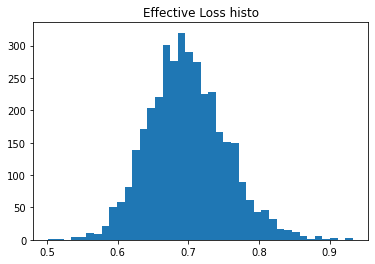

In [18]:
from tqdm.auto import tqdm

# train/validation per epoch
loss_values = []

loss_threshold_history.append((0, loss_threshold))

for epoch in range(num_epochs):

    # ========================================
    #               Training
    # ========================================

    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch + 1, num_epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_loss = 0
    skip_counter = 0
    
    progress_bar = tqdm(range(len(train_dataloader) * config_batch_size))

    for step, batch in enumerate(train_dataloader):
        '''
        if not step in included_batches:
            #print("skip batch", step)
            skip_counter += 1
            continue
        '''

        '''
        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed_mins, elapsed_secs = epoch_time(t0, time.time())            
            # Report progress.
            print(f'  Batch {step:>5,}  of  {len(train_dataloader):>5,}.    Elapsed: {elapsed_mins:}m {elapsed_secs:}s.')
        '''

        batch = {k: v.to(device) for k, v in batch.items()}
     
        # Fwd the whole batch
        model.eval()
        outputs = model(**batch)
        
        if config_per_sample: 
            loss = torch.nn.CrossEntropyLoss(reduction='none')(outputs.logits, batch['labels'])  # per example loss                    
            # loss history of all samples... discarded or not ...
            loss_history = np.concatenate((loss_history, loss.cpu().detach().numpy()))
        
            # backprop based on loss threshold 
            for idx, l in enumerate(loss):
                if l >= loss_threshold:
                    for k in ['input_ids', 'attention_mask', 'labels']:
                        #staged_batch[k] = torch.cat(staged_batch[k], batch[k][idx])
                        staged_batch[k].append(batch[k][idx])
                else:
                    skip_counter += 1 
                       
            #######################################
            # adjust loss threshold ... moving avg
            if len(loss_history) > config_n_window:
                loss_threshold = np.average(loss_history[-config_n_window:])
                loss_threshold_history.append((step * config_batch_size - skip_counter, loss_threshold))
        
            ''' # backprop based on loss ranking in the minibatch ... not working well
            lst = []
            for idx,l in enumerate(loss):
                lst.append((l.item(),idx))
            lst.sort(reverse=True)
            for l,idx in lst[0:int(len(lst)*keep_frac)]:
                for k in ['input_ids', 'attention_mask', 'labels']:
                    staged_batch[k].append(batch[k][idx])
            skip_counter += keep_frac
            '''
        
            optimizer.zero_grad()   # just in case ...
            
            # less than 1 batch for backprop ... later
            #n_batches = staged_batch['input_ids'].size(dim=0)
            n_batches = len(staged_batch['input_ids'])        
            # print("n_batches = ", n_batches)        
            if n_batches < config_batch_size:
                continue

            # has a batch to backprop ... split a batch of 8
            # https://pytorch.org/docs/stable/generated/torch.split.html            
            #batch = {'input_ids':[], 'attention_mask':[], 'labels':[]}

            for k in ['input_ids', 'attention_mask', 'labels']:
                # if n_batches == config_batch_size:
                #     batch[k] = torch.clone(staged_batch[k])
                # else: 
                #     batch[k], staged_batch[k] = torch.split(staged_batch[k], config_batch_size)
                #for b in staged_batch[k][0:config_batch_size]:

                # if k == 'labels':  # build a 1-d tensor for a list of 0-d tensors. can't cat
                #     batch[k] = torch.tensor(staged_batch[k][0:config_batch_size]).to(device)
                # else: # build 2d tensor from a list of 1d tensors. can cat
                #     batch[k] = torch.cat(staged_batch[k][0:config_batch_size]).to(device)  # already on device??

                batch[k] = torch.stack(staged_batch[k][0:config_batch_size]).to(device)  # already on device??
                staged_batch[k] = staged_batch[k][config_batch_size:]

        else: # per minibatch 
            loss = outputs.loss
            #loss_history.append(loss.cpu().detach().numpy())
            # np.concatenate((loss_history, loss.cpu().detach().numpy()))
            loss_history = np.append(loss_history, loss.item())
            
            #######################################
            # adjust loss threshold ... moving avg
            win = int(config_n_window / config_batch_size) 
            if len(loss_history) > win:
                loss_threshold = np.average(loss_history[-config_n_window:])
                loss_threshold_history.append((step * config_batch_size - skip_counter, loss_threshold))
                        
            if loss.item() < loss_threshold: 
                skip_counter += config_batch_size
                optimizer.zero_grad()   # just in case ...
                continue
                                                                                 
        model.train()
        outputs = model(**batch)
        loss = outputs.loss
        
        # loss is a tensor containing a single val
        total_loss += loss.item()
        #loss_history_eff.append((step, loss.item(), 1))   # 1 means backprop        
        # loss history of samples for training ... i.e. not discarded ...
        if config_per_sample:
            per_sample_loss = torch.nn.CrossEntropyLoss(reduction='none')(outputs.logits, batch['labels'])  # per example loss
            loss_history_eff = np.concatenate((loss_history_eff, per_sample_loss.cpu().detach().numpy()))
        else: 
            loss_history_eff = np.append(loss_history_eff, loss.item())

        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        # torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)        

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()

        progress_bar.update(config_batch_size)

    # Calculate the average loss over the training data.
    #avg_train_loss = total_loss / len(train_dataloader)     
    avg_train_loss = total_loss / (len(train_dataloader) - skip_counter / config_batch_size)   # xzl

    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

    print("")
    print(f"  Average training loss: {avg_train_loss:.2f}")
    print("  Training epcoh took: {:}m {:}s".format(*epoch_time(t0, time.time())))    
    print(f"  skipped {skip_counter} samples, {100 * skip_counter/config_batch_size/len(train_dataloader):.2f}%", "loss_threshold", loss_threshold)
    
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    for batch in eval_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)

        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)
        metric.add_batch(predictions=predictions, references=batch["labels"])

    print("  Validation took: {:}m {:}s".format(*epoch_time(t0, time.time())))
    print("Accuracy: ", metric.compute())    
    
# print(loss_history)
%matplotlib inline
plt.hist(loss_history_eff, bins=40)
plt.title("Effective Loss histo")

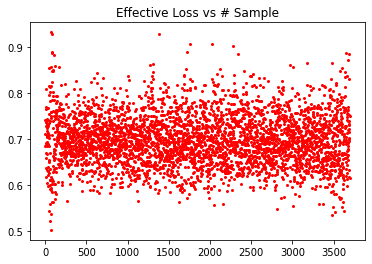

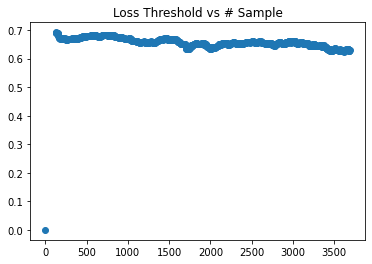

In [19]:
plt.title("Effective Loss vs # Sample")
plt.plot(loss_history_eff, 'ro', markersize=2)
plt.show()

plt.title("Loss Threshold vs # Sample")
ts = np.transpose(loss_threshold_history)
plt.scatter(ts[0],ts[1])
plt.show()

# end of plot

In [ ]:
#print(optimizer.state['grad_history'])

# gradient ... low to high
s = sorted(optimizer.state['grad_history'], key = lambda x: x[1])    
# loss  ... low to high
# s = sorted(loss_history, key = lambda x: x[1])    

plt.hist(list(map(lambda x: x[1], optimizer.state['grad_history'])), bins=40)
plt.title("Gradient histo")

#print(s)
#print(s[int(9*len(s)/10):-1])  # top 10% 
#print(s[90:-1])
bottom10 = s[0:int(1*len(s)/10)]
bottom50 = s[0:int(5*len(s)/10)]
bottom75 = s[0:int(7.5*len(s)/10)]
bottom90 = s[0:int(9*len(s)/10)]

top10 = s[int(9*len(s)/10):-1]
top25 = s[int(7.5*len(s)/10):-1]

#print("bot50", bottom50)
#print("bot50", bottom50[-1])
#print("top10", top10)
#print("top10", top10[0])

included_batches = [x[0] for x in bottom10] 
for x in included_batches:
    print(x, end=',')

In [ ]:
# train all epoches (no validation)

from tqdm.auto import tqdm

progress_bar = tqdm(range(num_training_steps))

model.train()
for epoch in range(num_epochs):
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

In [ ]:
# validation

from datasets import load_metric

#metric = load_metric("glue", "mrpc")
metric = load_metric("glue", "sst2")  # same as accuracy
# metric = load_metric("accuracy")
model.eval()
for batch in eval_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
    metric.add_batch(predictions=predictions, references=batch["labels"])

metric.compute()